# Librerie

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import OLS, add_constant
#----------------------------------------------------------------------------
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Serie Giorni

In [2]:
# Scaricare i dati di Bitcoin
start_date = '2017-01-01'
end_date = '2024-10-31'
btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
print(btc_data.head())

[*********************100%***********************]  1 of 1 completed

Price                        Adj Close        Close         High          Low  \
Ticker                         BTC-USD      BTC-USD      BTC-USD      BTC-USD   
Date                                                                            
2017-01-01 00:00:00+00:00   998.325012   998.325012  1003.080017   958.698975   
2017-01-02 00:00:00+00:00  1021.750000  1021.750000  1031.390015   996.702026   
2017-01-03 00:00:00+00:00  1043.839966  1043.839966  1044.079956  1021.599976   
2017-01-04 00:00:00+00:00  1154.729980  1154.729980  1159.420044  1044.400024   
2017-01-05 00:00:00+00:00  1013.380005  1013.380005  1191.099976   910.416992   

Price                             Open     Volume  
Ticker                         BTC-USD    BTC-USD  
Date                                               
2017-01-01 00:00:00+00:00   963.658020  147775008  
2017-01-02 00:00:00+00:00   998.617004  222184992  
2017-01-03 00:00:00+00:00  1021.599976  185168000  
2017-01-04 00:00:00+00:00  1044.400024 

## Selezione serie 

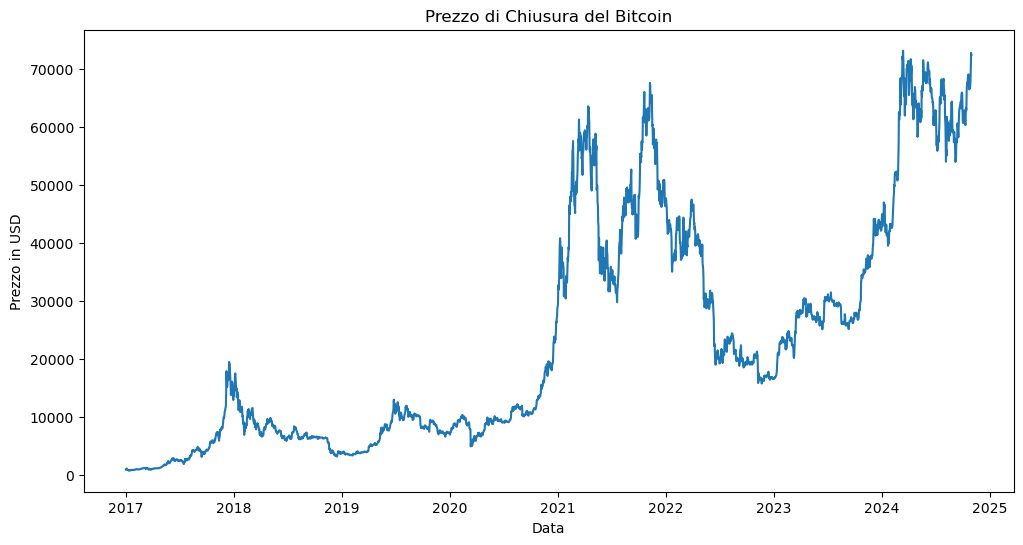

In [3]:
btc_data = btc_data[['Close']]  # Usare solo i prezzi di chiusura
btc_data.dropna(inplace=True)

# OSSERVIAMO LA SERIE

plt.figure(figsize=(12,6))
plt.plot(btc_data['Close'])
plt.title('Prezzo di Chiusura del Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo in USD')
plt.show()

## Test sulla costanza della varianza

In [4]:
# 2. Calcola i residui con una regressione semplice (usando un trend temporale)
trend = np.arange(len(btc_data['Close']))
model = OLS(btc_data['Close'], add_constant(trend)).fit()
residuals = model.resid

# 3. Test di Breusch-Pagan
test_stat, p_value, _, _ = het_breuschpagan(residuals, add_constant(trend))
print(f"Statistica Breusch-Pagan: {test_stat}")
print(f"p-value: {p_value}")

# Interpreta il risultato
if p_value < 0.05:
    print("La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.")
else:
    print("La varianza è costante (non è necessaria una trasformazione logaritmica).")

Statistica Breusch-Pagan: 429.022431776016
p-value: 2.6525051661607006e-95
La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.


In [5]:
# Trasformazione logaritmica per ridurre la varianza
btc_data['Log_Close'] = np.log(btc_data['Close'])

In [6]:
# 2. Calcola i residui con una regressione semplice (usando un trend temporale)
trend = np.arange(len(btc_data['Log_Close']))
model = OLS(btc_data['Log_Close'], add_constant(trend)).fit()
residuals = model.resid

# 3. Test di Breusch-Pagan
test_stat, p_value, _, _ = het_breuschpagan(residuals, add_constant(trend))
print(f"Statistica Breusch-Pagan: {test_stat}")
print(f"p-value: {p_value}")

# Interpreta il risultato
if p_value < 0.05:
    print("La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.")
else:
    print("La varianza è costante (non è necessaria una trasformazione logaritmica).")

Statistica Breusch-Pagan: 180.70824612486444
p-value: 3.3945569306874635e-41
La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.


## Test sulla varianza 

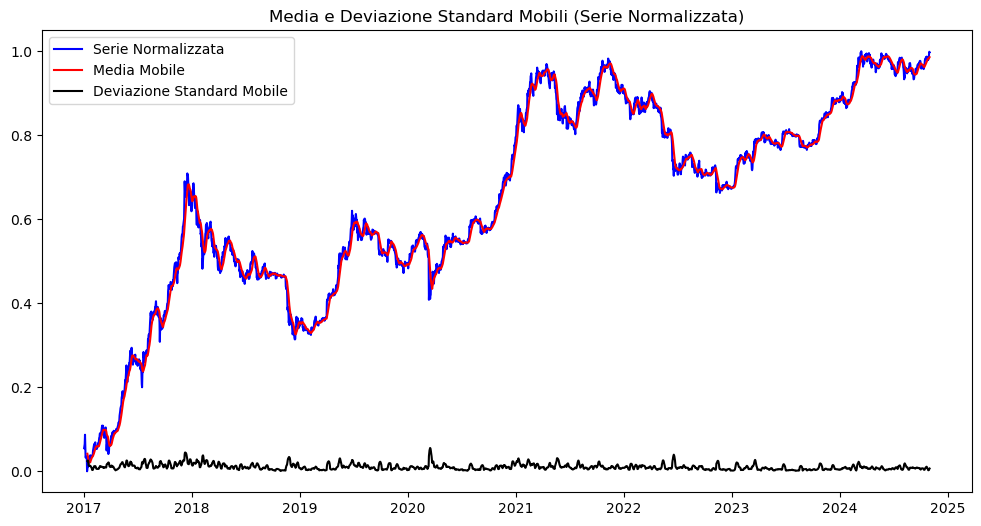

Risultati del Test di Dickey-Fuller:
Statistiche del Test              -1.981535
p-value                            0.294727
# Lags Used                        2.000000
Numero di Osservazioni Usate    2857.000000
Valore Critico (1%)               -3.432641
Valore Critico (5%)               -2.862552
Valore Critico (10%)              -2.567309
dtype: float64


In [7]:
# FUNZIONE PER CALCOLARE MEDIA MOBILE, DEVIAZIONE STANDARD MOBILE E ESEGUEGUIRE UN TEST DI DICKEY-FULLER PER CONTROLLARE STAZIOANRIETÀ  E NUMERO DI LAG
def test_stationarity(timeseries):
    # Normalizzazione della serie
    normalized_series = (timeseries - timeseries.min()) / (timeseries.max() - timeseries.min())

    # Calcolo della media mobile e della deviazione standard mobile
    rolmean = normalized_series.rolling(window=12).mean()
    rolstd = normalized_series.rolling(window=12).std()

    # Plot della serie originale, media mobile e deviazione standard
    plt.figure(figsize=(12,6))
    plt.plot(normalized_series, color='blue', label='Serie Normalizzata')
    plt.plot(rolmean, color='red', label='Media Mobile')
    plt.plot(rolstd, color='black', label='Deviazione Standard Mobile')
    plt.legend(loc='best')
    plt.title('Media e Deviazione Standard Mobili (Serie Normalizzata)')
    plt.show()

    # Test di Dickey-Fuller
    print('Risultati del Test di Dickey-Fuller:')
    dftest = adfuller(normalized_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Statistiche del Test','p-value','# Lags Used','Numero di Osservazioni Usate'])
    for key,value in dftest[4].items():
        dfoutput['Valore Critico (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(btc_data['Log_Close'])    

In [8]:
# Se la serie non è stazionaria, APPLICHIAMO LA DIFFERNZIAZIONE p-value > 0.05
dif_btc_data = btc_data['Log_Close'].diff().dropna()

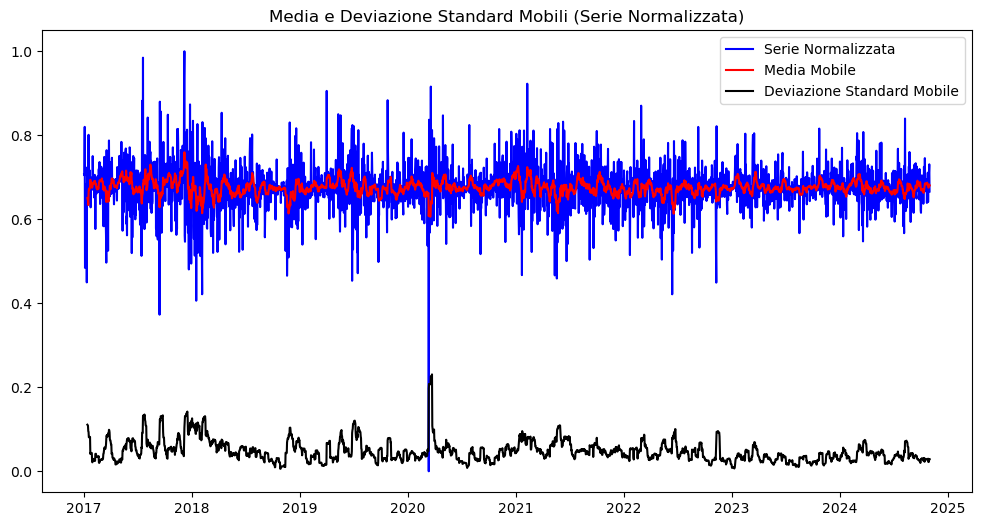

Risultati del Test di Dickey-Fuller:
Statistiche del Test             -36.906519
p-value                            0.000000
# Lags Used                        1.000000
Numero di Osservazioni Usate    2857.000000
Valore Critico (1%)               -3.432641
Valore Critico (5%)               -2.862552
Valore Critico (10%)              -2.567309
dtype: float64


In [9]:
test_stationarity(dif_btc_data)

#### d=1

## Parametri
### Test per p e q
#### MINIC

In [10]:
def find_minic(time_series, max_p=5, max_q=5):
    results = []
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(time_series, order=(p, 0, q)).fit()
                results.append((p, q, model.aic))
            except:
                continue
    results_df = pd.DataFrame(results, columns=["p", "q", "AIC"])
    best_model = results_df.loc[results_df['AIC'].idxmin()]
    return results_df, best_model

# Test con MINIC
time_series = dif_btc_data
results_df, best_model = find_minic(dif_btc_data)
print("Miglior modello MINIC:", best_model)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

Miglior modello MINIC: p          2.000000
q          0.000000
AIC   -10603.399185
Name: 12, dtype: float64


##### mimic p=2  - q=0

#### SCAN

In [11]:
def find_scan(time_series, max_p=5, max_q=5):
    results = []
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(time_series, order=(p, 0, q)).fit()
                residuals = model.resid
                acf_resid = acf(residuals, fft=False)
                pacf_resid = pacf(residuals)
                residual_quality = np.sum(np.abs(acf_resid[1:5])) + np.sum(np.abs(pacf_resid[1:5]))
                results.append((p, q, residual_quality))
            except:
                continue
    results_df = pd.DataFrame(results, columns=["p", "q", "Residual_Quality"])
    best_model = results_df.loc[results_df['Residual_Quality'].idxmin()]
    return results_df, best_model

# Test con SCAN
results_df, best_model = find_scan(dif_btc_data)
print("Miglior modello SCAN:", best_model)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

Miglior modello SCAN: p                   4.000000
q                   3.000000
Residual_Quality    0.001491
Name: 27, dtype: float64


##### SCAN p=4 - q=3

#### ESACF

Plotting ACF and PACF for ESACF analysis...
Osserva i grafici per determinare p e q.


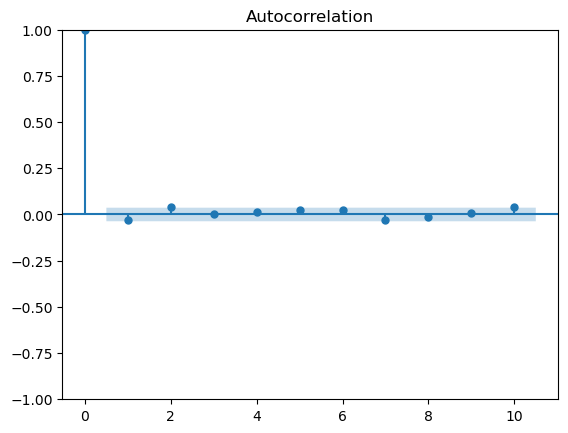

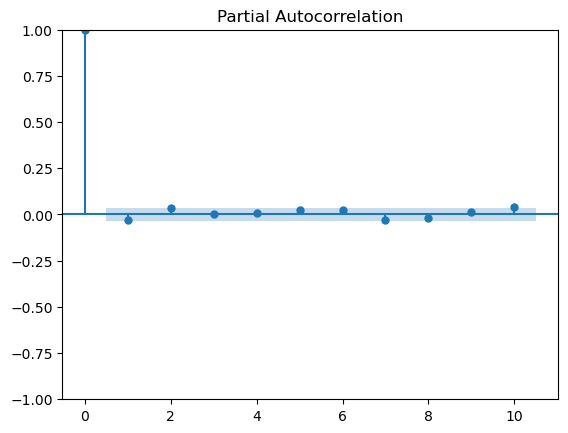

In [12]:
def esacf_analysis(time_series, max_p=5, max_q=5):
    print("Plotting ACF and PACF for ESACF analysis...")
    plot_acf(time_series, lags=max_p + max_q)
    plot_pacf(time_series, lags=max_p + max_q)
    # Si possono osservare i grafici per scegliere manualmente p e q
    print("Osserva i grafici per determinare p e q.")
    return

# Test con ESACF
esacf_analysis(dif_btc_data)

## Modello
### Importiamo il test

[*********************100%***********************]  1 of 1 completed


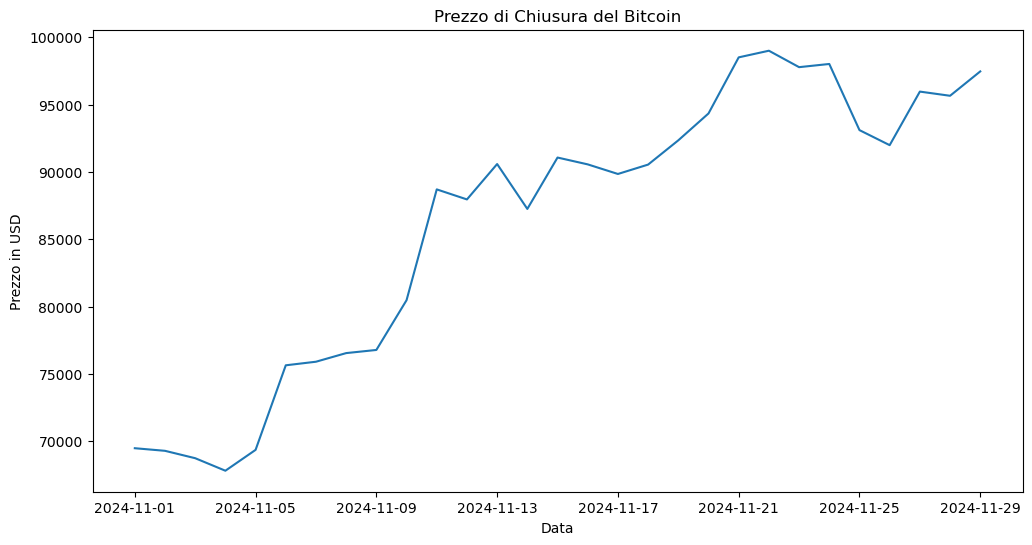

In [13]:
# Import del mese di test 
test_start_date = '2024-11-01'
test_end_date = '2024-11-30'

test_data = yf.download('BTC-USD', start=test_start_date, end=test_end_date)
test_data = test_data[['Close']]
test_data.dropna(inplace=True)

plt.figure(figsize=(12,6))
plt.plot(test_data)
plt.title('Prezzo di Chiusura del Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo in USD')
plt.show()

### Modello MIMIC

In [14]:
p = 2
q = 0
d = 1

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2860
Model:                 ARIMA(2, 1, 0)   Log Likelihood                5303.508
Date:                Thu, 09 Jan 2025   AIC                         -10601.016
Time:                        11:49:40   BIC                         -10583.142
Sample:                    01-01-2017   HQIC                        -10594.571
                         - 10-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0260      0.013     -2.059      0.040      -0.051      -0.001
ar.L2          0.0390      0.016      2.507      0.012       0.009       0.070
sigma2         0.0014   1.48e-05     96.941      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### Test

Metriche di valutazione:
MAE: 14993.521294371241
RMSE: 17243.715333780096


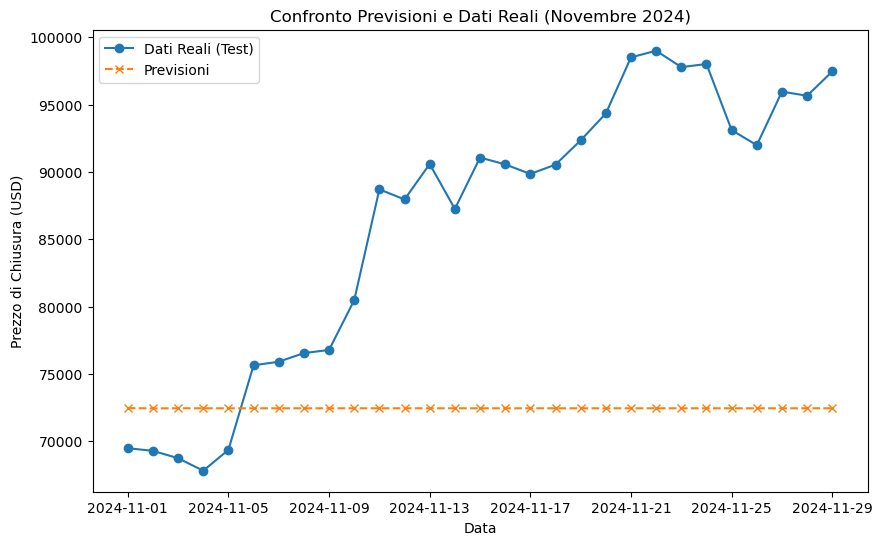

In [15]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

### Modello SCAN

In [16]:
p = 4
q = 3
d = 1

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA par

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2860
Model:                 ARIMA(4, 1, 3)   Log Likelihood                5305.485
Date:                Thu, 09 Jan 2025   AIC                         -10594.971
Time:                        11:49:41   BIC                         -10547.305
Sample:                    01-01-2017   HQIC                        -10577.784
                         - 10-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1243      0.474     -0.262      0.793      -1.053       0.805
ar.L2          0.3244      0.407      0.796      0.426      -0.474       1.123
ar.L3          0.6820      0.396      1.721      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Test

Metriche di valutazione:
MAE: 14051.460376635489
RMSE: 16145.74374189207


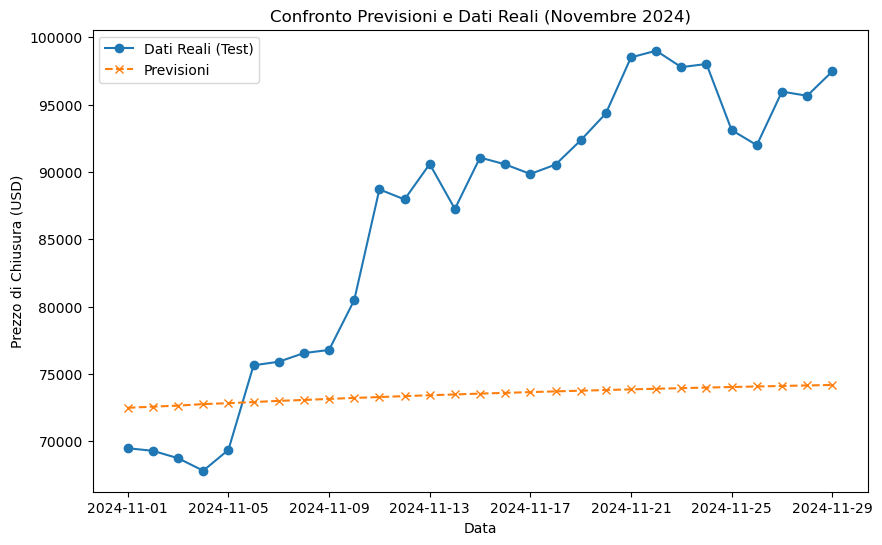

In [17]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

### Modello ESACF

In [18]:
p = 1
q = 1
d = 1

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2860
Model:                 ARIMA(1, 1, 1)   Log Likelihood                5302.293
Date:                Thu, 09 Jan 2025   AIC                         -10598.585
Time:                        11:49:41   BIC                         -10580.711
Sample:                    01-01-2017   HQIC                        -10592.140
                         - 10-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3768      0.366     -1.031      0.303      -1.093       0.340
ma.L1          0.3425      0.369      0.928      0.353      -0.381       1.066
sigma2         0.0014   1.48e-05     96.853      0.0

#### Test

Metriche di valutazione:
MAE: 15045.599308374241
RMSE: 17307.36740836971


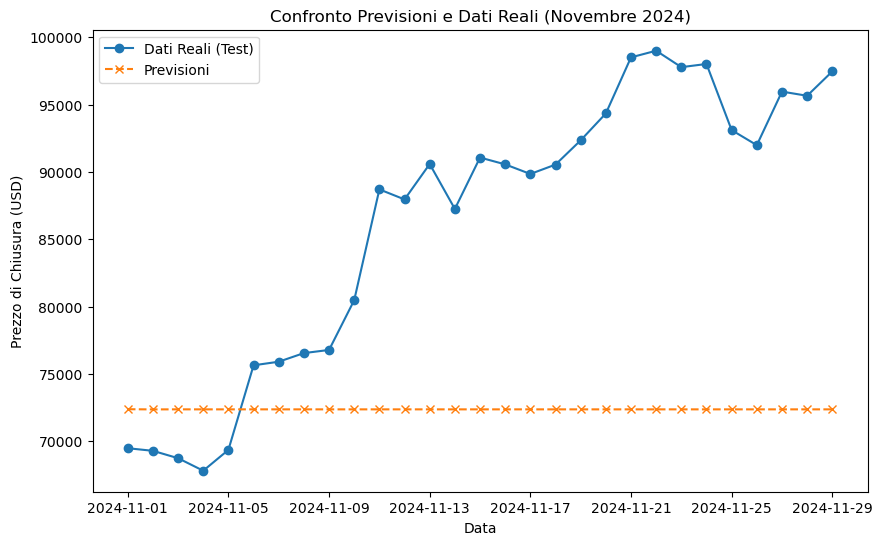

In [19]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

### Modello migliore

In [20]:
p = 1
q = 1
d = 3

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2860
Model:                 ARIMA(1, 3, 1)   Log Likelihood                4739.344
Date:                Thu, 09 Jan 2025   AIC                          -9472.687
Time:                        11:49:41   BIC                          -9454.815
Sample:                    01-01-2017   HQIC                         -9466.243
                         - 10-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5322      0.010    -53.302      0.000      -0.552      -0.513
ma.L1         -1.0000      1.983     -0.504      0.614      -4.887       2.887
sigma2         0.0021      0.004      0.505      0.6

#### Test

Metriche di valutazione:
MAE: 4233.983767494507
RMSE: 4908.186468415709


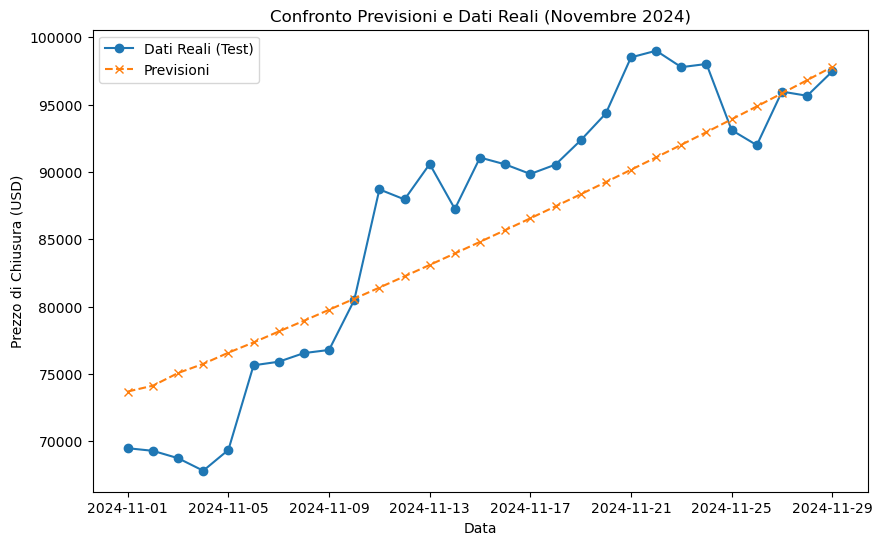

In [21]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

-----------------------------------------

# Serie Minuti

In [22]:
# Scarica dati di Bitcoin al minuto
df = yf.download('BTC-USD', start='2024-12-28', end='2025-01-05', interval='1m')

# Controlla i dati scaricati
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price                         Adj Close         Close          High  \
Ticker                          BTC-USD       BTC-USD       BTC-USD   
Datetime                                                              
2024-12-28 00:01:00+00:00  94159.828125  94159.828125  94159.828125   
2024-12-28 00:02:00+00:00  94164.929688  94164.929688  94164.929688   
2024-12-28 00:03:00+00:00  94243.117188  94243.117188  94243.117188   
2024-12-28 00:04:00+00:00  94219.835938  94219.835938  94219.835938   
2024-12-28 00:05:00+00:00  94236.851562  94236.851562  94236.851562   

Price                               Low          Open    Volume  
Ticker                          BTC-USD       BTC-USD   BTC-USD  
Datetime                                                         
2024-12-28 00:01:00+00:00  94159.828125  94159.828125         0  
2024-12-28 00:02:00+00:00  94164.929688  94164.929688         0  
2024-12-28 00:03:00+00:00  94243.117188  94243.117188         0  
2024-12-28 00:04:00+00:00  94219.83

## Selezione serie

/var/folders/xz/btvnch3d3cl8ps_ncznqsfn00000gn/T/ipykernel_13424/1849390894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data.dropna(inplace=True)


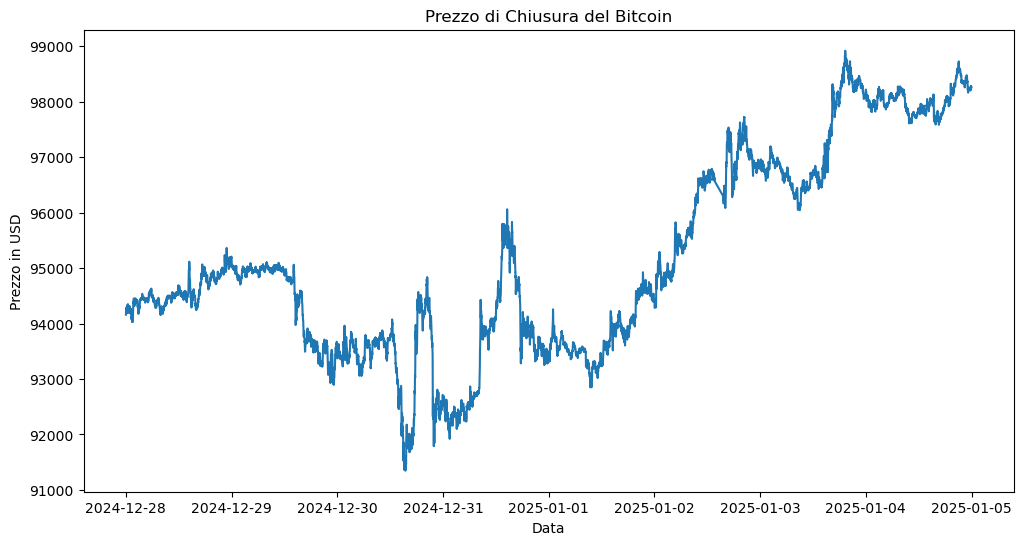

In [23]:
btc_data = df[['Close']]  # Usare solo i prezzi di chiusura
btc_data.dropna(inplace=True)

# OSSERVIAMO LA SERIE

plt.figure(figsize=(12,6))
plt.plot(btc_data['Close'])
plt.title('Prezzo di Chiusura del Bitcoin')
plt.xlabel('Data')
plt.ylabel('Prezzo in USD')
plt.show()

## Test costanza della varianza

In [24]:
# 2. Calcola i residui con una regressione semplice (usando un trend temporale)
trend = np.arange(len(btc_data['Close']))
model = OLS(btc_data['Close'], add_constant(trend)).fit()
residuals = model.resid

# 3. Test di Breusch-Pagan
test_stat, p_value, _, _ = het_breuschpagan(residuals, add_constant(trend))
print(f"Statistica Breusch-Pagan: {test_stat}")
print(f"p-value: {p_value}")

# Interpreta il risultato
if p_value < 0.05:
    print("La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.")
else:
    print("La varianza è costante (non è necessaria una trasformazione logaritmica).")

Statistica Breusch-Pagan: 722.6264819997814
p-value: 3.593663352900418e-159
La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.


In [25]:
# Trasformazione logaritmica per ridurre la varianza
btc_data['Log_Close'] = np.log(btc_data['Close'])

/var/folders/xz/btvnch3d3cl8ps_ncznqsfn00000gn/T/ipykernel_13424/954759016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_data['Log_Close'] = np.log(btc_data['Close'])


In [26]:
# 2. Calcola i residui con una regressione semplice (usando un trend temporale)
trend = np.arange(len(btc_data['Close']))
model = OLS(btc_data['Close'], add_constant(trend)).fit()
residuals = model.resid

# 3. Test di Breusch-Pagan
test_stat, p_value, _, _ = het_breuschpagan(residuals, add_constant(trend))
print(f"Statistica Breusch-Pagan: {test_stat}")
print(f"p-value: {p_value}")

# Interpreta il risultato
if p_value < 0.05:
    print("La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.")
else:
    print("La varianza è costante (non è necessaria una trasformazione logaritmica).")

Statistica Breusch-Pagan: 722.6264819997814
p-value: 3.593663352900418e-159
La varianza non è costante (eteroschedasticità rilevata). Potrebbe essere utile una trasformazione logaritmica.


## Test sulla varianza

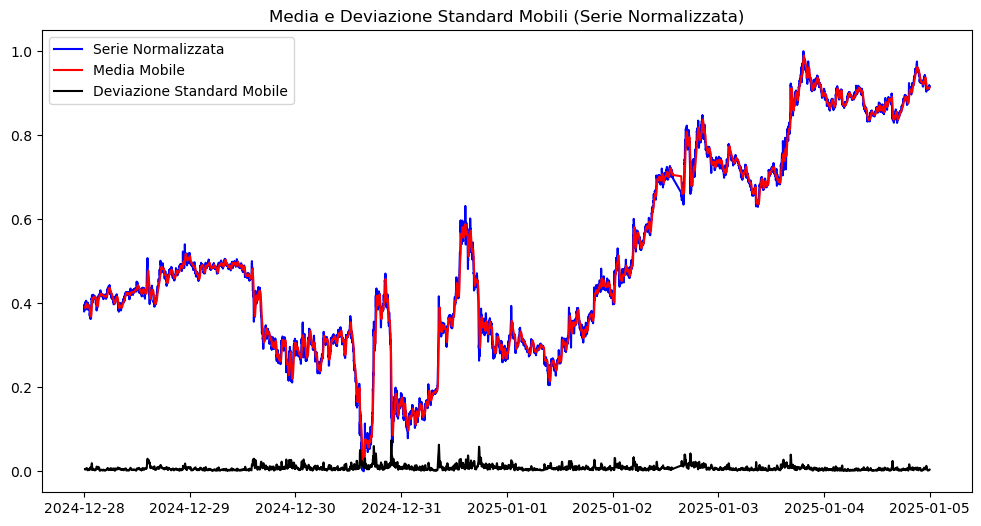

Risultati del Test di Dickey-Fuller:
Statistiche del Test              -0.998904
p-value                            0.753664
# Lags Used                        8.000000
Numero di Osservazioni Usate    8688.000000
Valore Critico (1%)               -3.431103
Valore Critico (5%)               -2.861873
Valore Critico (10%)              -2.566947
dtype: float64


In [27]:
# FUNZIONE PER CALCOLARE MEDIA MOBILE E DEVIAZIONE STANDARD MOBILE, INOLTRE ESEGUE UN TEST DI DICKEY-FULLER PER CONTROLLARE STAZIOANRIETÀ  E NUMERO DI LAG
def test_stationarity(timeseries):
    # Normalizzazione della serie
    normalized_series = (timeseries - timeseries.min()) / (timeseries.max() - timeseries.min())

    # Calcolo della media mobile e della deviazione standard mobile
    rolmean = normalized_series.rolling(window=12).mean()
    rolstd = normalized_series.rolling(window=12).std()

    # Plot della serie originale, media mobile e deviazione standard
    plt.figure(figsize=(12,6))
    plt.plot(normalized_series, color='blue', label='Serie Normalizzata')
    plt.plot(rolmean, color='red', label='Media Mobile')
    plt.plot(rolstd, color='black', label='Deviazione Standard Mobile')
    plt.legend(loc='best')
    plt.title('Media e Deviazione Standard Mobili (Serie Normalizzata)')
    plt.show()

    # Test di Dickey-Fuller
    print('Risultati del Test di Dickey-Fuller:')
    dftest = adfuller(normalized_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Statistiche del Test','p-value','# Lags Used','Numero di Osservazioni Usate'])
    for key,value in dftest[4].items():
        dfoutput['Valore Critico (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(btc_data['Log_Close']) 

In [28]:
# Se la serie non è stazionaria, APPLICHIAMO LA DIFFERNZIAZIONE p-value > 0.05
dif_btc_data = btc_data['Log_Close'].diff().dropna()

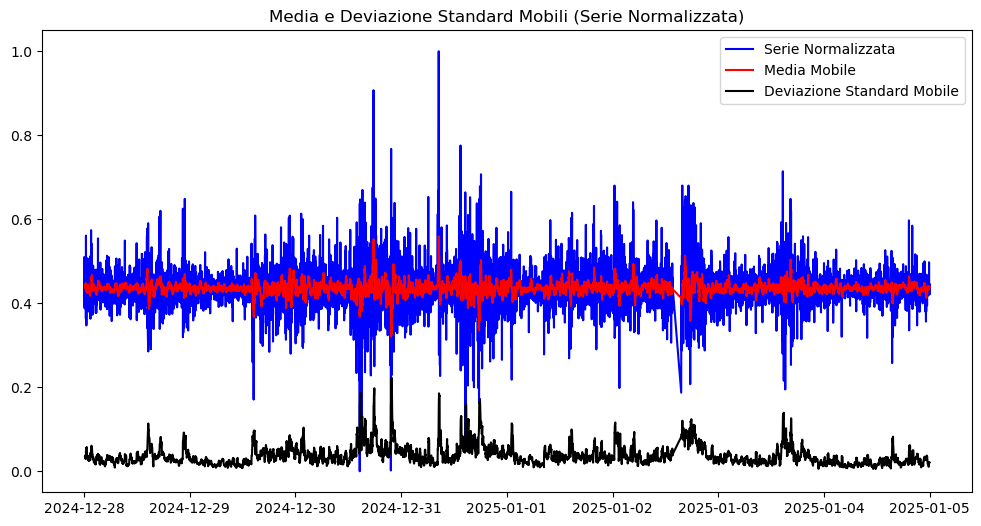

Risultati del Test di Dickey-Fuller:
Statistiche del Test             -22.035906
p-value                            0.000000
# Lags Used                       20.000000
Numero di Osservazioni Usate    8675.000000
Valore Critico (1%)               -3.431104
Valore Critico (5%)               -2.861873
Valore Critico (10%)              -2.566947
dtype: float64


In [29]:
# FUNZIONE PER CALCOLARE MEDIA MOBILE E DEVIAZIONE STANDARD MOBILE, INOLTRE ESEGUE UN TEST DI DICKEY-FULLER PER CONTROLLARE STAZIOANRIETÀ  E NUMERO DI LAG
def test_stationarity(timeseries):
    # Normalizzazione della serie
    normalized_series = (timeseries - timeseries.min()) / (timeseries.max() - timeseries.min())

    # Calcolo della media mobile e della deviazione standard mobile
    rolmean = normalized_series.rolling(window=12).mean()
    rolstd = normalized_series.rolling(window=12).std()

    # Plot della serie originale, media mobile e deviazione standard
    plt.figure(figsize=(12,6))
    plt.plot(normalized_series, color='blue', label='Serie Normalizzata')
    plt.plot(rolmean, color='red', label='Media Mobile')
    plt.plot(rolstd, color='black', label='Deviazione Standard Mobile')
    plt.legend(loc='best')
    plt.title('Media e Deviazione Standard Mobili (Serie Normalizzata)')
    plt.show()

    # Test di Dickey-Fuller
    print('Risultati del Test di Dickey-Fuller:')
    dftest = adfuller(normalized_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Statistiche del Test','p-value','# Lags Used','Numero di Osservazioni Usate'])
    for key,value in dftest[4].items():
        dfoutput['Valore Critico (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(dif_btc_data) 

## Parametri
### Test per p e q
#### MINIC

In [30]:
def find_minic(time_series, max_p=5, max_q=5):
    results = []
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(time_series, order=(p, 0, q)).fit()
                results.append((p, q, model.aic))
            except:
                continue
    results_df = pd.DataFrame(results, columns=["p", "q", "AIC"])
    best_model = results_df.loc[results_df['AIC'].idxmin()]
    return results_df, best_model

# Test con MINIC
time_series = dif_btc_data
results_df, best_model = find_minic(dif_btc_data)
print("Miglior modello MINIC:", best_model)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

Miglior modello MINIC: p           1.000000
q           1.000000
AIC   -106756.249385
Name: 7, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### MINIC p=1 q=1

#### SCAN

In [31]:
def find_scan(time_series, max_p=5, max_q=5):
    results = []
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(time_series, order=(p, 0, q)).fit()
                residuals = model.resid
                acf_resid = acf(residuals, fft=False)
                pacf_resid = pacf(residuals)
                residual_quality = np.sum(np.abs(acf_resid[1:5])) + np.sum(np.abs(pacf_resid[1:5]))
                results.append((p, q, residual_quality))
            except:
                continue
    results_df = pd.DataFrame(results, columns=["p", "q", "Residual_Quality"])
    best_model = results_df.loc[results_df['Residual_Quality'].idxmin()]
    return results_df, best_model

# Test con SCAN
results_df, best_model = find_scan(dif_btc_data)
print("Miglior modello SCAN:", best_model)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

Miglior modello SCAN: p                   4.000000
q                   0.000000
Residual_Quality    0.001773
Name: 24, dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


##### SCAN p=4  q=0

#### ESACF

Plotting ACF and PACF for ESACF analysis...
Osserva i grafici per determinare p e q.


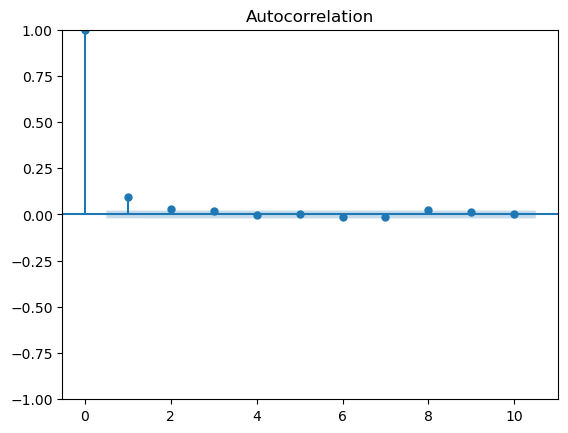

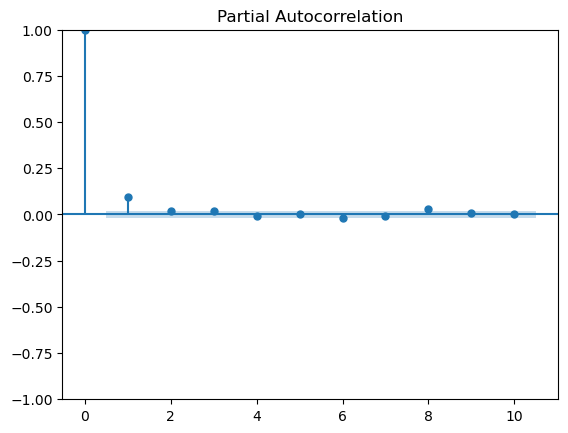

In [32]:
def esacf_analysis(time_series, max_p=5, max_q=5):
    print("Plotting ACF and PACF for ESACF analysis...")
    plot_acf(time_series, lags=max_p + max_q)
    plot_pacf(time_series, lags=max_p + max_q)
    # Si possono osservare i grafici per scegliere manualmente p e q
    print("Osserva i grafici per determinare p e q.")
    return

# Test con ESACF
esacf_analysis(dif_btc_data)

## Modello
### Importiamo il test 

In [33]:
# Suddividere i dati in addestramento e test 
train_data = btc_data['Log_Close']
test_start_date = '2025-01-05'
test_end_date = '2025-01-06'
test_data = yf.download('BTC-USD', start=test_start_date, end=test_end_date, interval='1m')
test_data = test_data[['Close']]
test_data.dropna(inplace=True)

print(test_data.head())

[*********************100%***********************]  1 of 1 completed

Price                             Close
Ticker                          BTC-USD
Datetime                               
2025-01-05 00:00:00+00:00  98211.265625
2025-01-05 00:01:00+00:00  98232.382812
2025-01-05 00:03:00+00:00  98209.695312
2025-01-05 00:05:00+00:00  98149.664062
2025-01-05 00:06:00+00:00  98156.304688


### Modello MIMIC

In [34]:
p = 1
q = 1
d = 1

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 8697
Model:                 ARIMA(1, 1, 1)   Log Likelihood               53381.830
Date:                Thu, 09 Jan 2025   AIC                        -106757.659
Time:                        11:51:11   BIC                        -106736.447
Sample:                             0   HQIC                       -106750.429
                               - 8697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3253      0.002    130.888      0.000       0.320       0.330
ma.L1         -0.2321      0.002    -96.862      0.000      -0.237      -0.227
sigma2      2.725e-07   1.62e-09    167.815      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Test

Metriche di valutazione:
MAE: 272.5168018976256
RMSE: 338.78798694833654


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


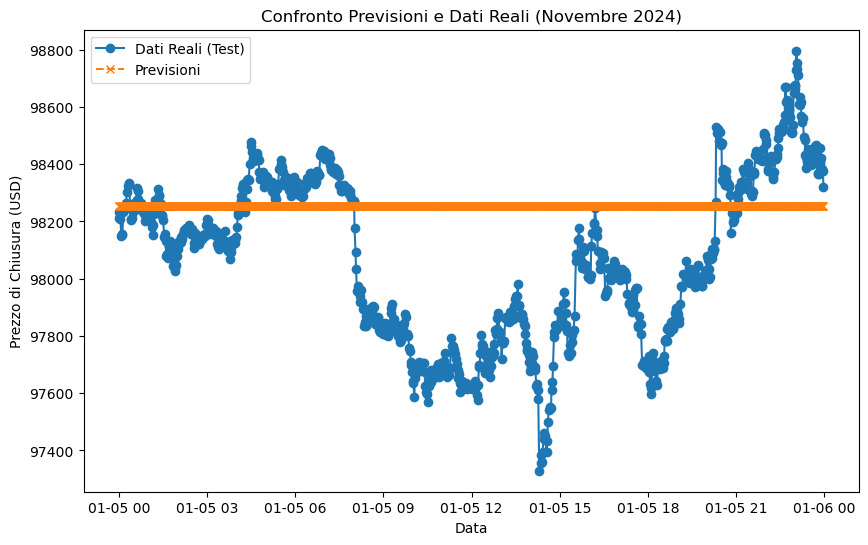

In [35]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

### Modello SCAN

In [36]:
p = 4
q = 0
d = 1

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 8697
Model:                 ARIMA(4, 1, 0)   Log Likelihood               53382.803
Date:                Thu, 09 Jan 2025   AIC                        -106755.606
Time:                        11:51:12   BIC                        -106720.252
Sample:                             0   HQIC                       -106743.555
                               - 8697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0934      0.005     17.731      0.000       0.083       0.104
ar.L2          0.0180      0.006      2.856      0.004       0.006       0.030
ar.L3          0.0179      0.006      3.017      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Test

Metriche di valutazione:
MAE: 272.52341454737774
RMSE: 338.7992477593677


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


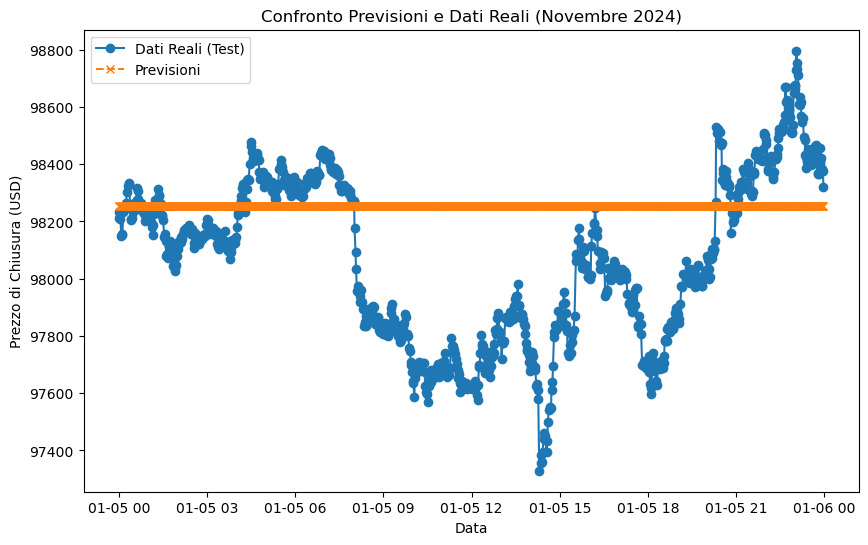

In [37]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

### Modello ESACF

In [38]:
p = 2
q = 2
d = 1

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 8697
Model:                 ARIMA(2, 1, 2)   Log Likelihood               53382.437
Date:                Thu, 09 Jan 2025   AIC                        -106754.875
Time:                        11:51:13   BIC                        -106719.522
Sample:                             0   HQIC                       -106742.824
                               - 8697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4173      0.003   -166.430      0.000      -0.422      -0.412
ar.L2          0.3401      0.003    128.697      0.000       0.335       0.345
ma.L1          0.5108      0.002    216.257      0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Test

Metriche di valutazione:
MAE: 272.39900036701704
RMSE: 338.58817268136477


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


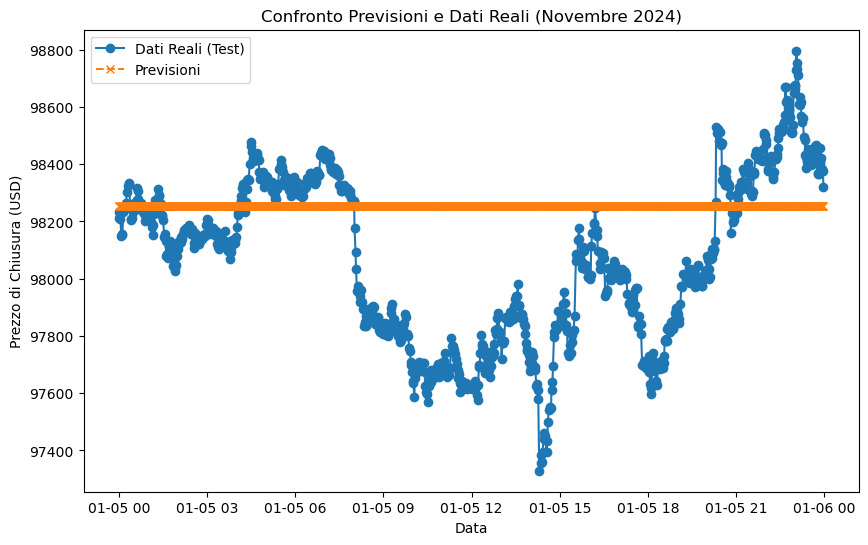

In [39]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()

### Modello test

In [40]:
p = 1
q = 1
d = 2

# Creazione e addestramento del modello ARIMA con la serie logaritmica
model = ARIMA(btc_data['Log_Close'], order= (p, d, q))
fitted_model = model.fit()

# Sommario del modello
print(fitted_model.summary())

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 8697
Model:                 ARIMA(1, 2, 1)   Log Likelihood               52820.841
Date:                Thu, 09 Jan 2025   AIC                        -105635.683
Time:                        11:51:14   BIC                        -105614.471
Sample:                             0   HQIC                       -105628.453
                               - 8697                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0588      0.008      6.930      0.000       0.042       0.075
ma.L1         -0.7373      0.007    -98.859      0.000      -0.752      -0.723
sigma2       3.09e-07   2.18e-09    141.552      0.0

#### Test

Metriche di valutazione:
MAE: 248.07103371229522
RMSE: 306.5550304761614


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


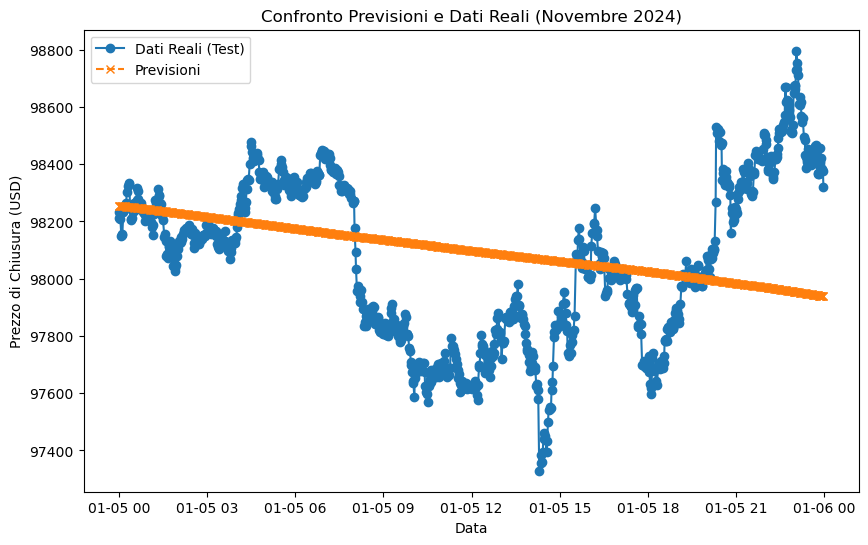

In [41]:
# Previsione sui dati di test (novembre 2024)
forecast = fitted_model.forecast(steps=len(test_data))
forecast = np.exp(forecast)  # Tornare ai valori originali dal log

# Calcolo metriche di valutazione
mae = mean_absolute_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))
print(f"Metriche di valutazione:\nMAE: {mae}\nRMSE: {rmse}")

# Grafico delle previsioni rispetto ai dati reali
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['Close'], label='Dati Reali (Test)', marker='o')
plt.plot(test_data.index, forecast, label='Previsioni', linestyle='--', marker='x')
plt.title('Confronto Previsioni e Dati Reali (Novembre 2024)')
plt.xlabel('Data')
plt.ylabel('Prezzo di Chiusura (USD)')
plt.legend()
plt.show()